Created on Sun Nov 10 15:26:09 2024
@author: hanna.dunska


# Step 1. Import Libraries 


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.preprocessing import KBinsDiscretizer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import TargetEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader


import warnings
# filter warnings
warnings.filterwarnings('ignore')

# Step 2. Data Loading

In [2]:
df = pd.read_csv('/Users/hanna.dunska/Desktop/Deep Learning/Homework/ConcreteStrengthData.csv')
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   CementComponent            1030 non-null   float64
 1   BlastFurnaceSlag           1030 non-null   float64
 2   FlyAshComponent            1030 non-null   float64
 3   WaterComponent             1030 non-null   float64
 4   SuperplasticizerComponent  1030 non-null   float64
 5   CoarseAggregateComponent   1030 non-null   float64
 6   FineAggregateComponent     1030 non-null   float64
 7   AgeInDays                  1030 non-null   int64  
 8   Strength                   1030 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 72.6 KB


# Step 3. Data Overview

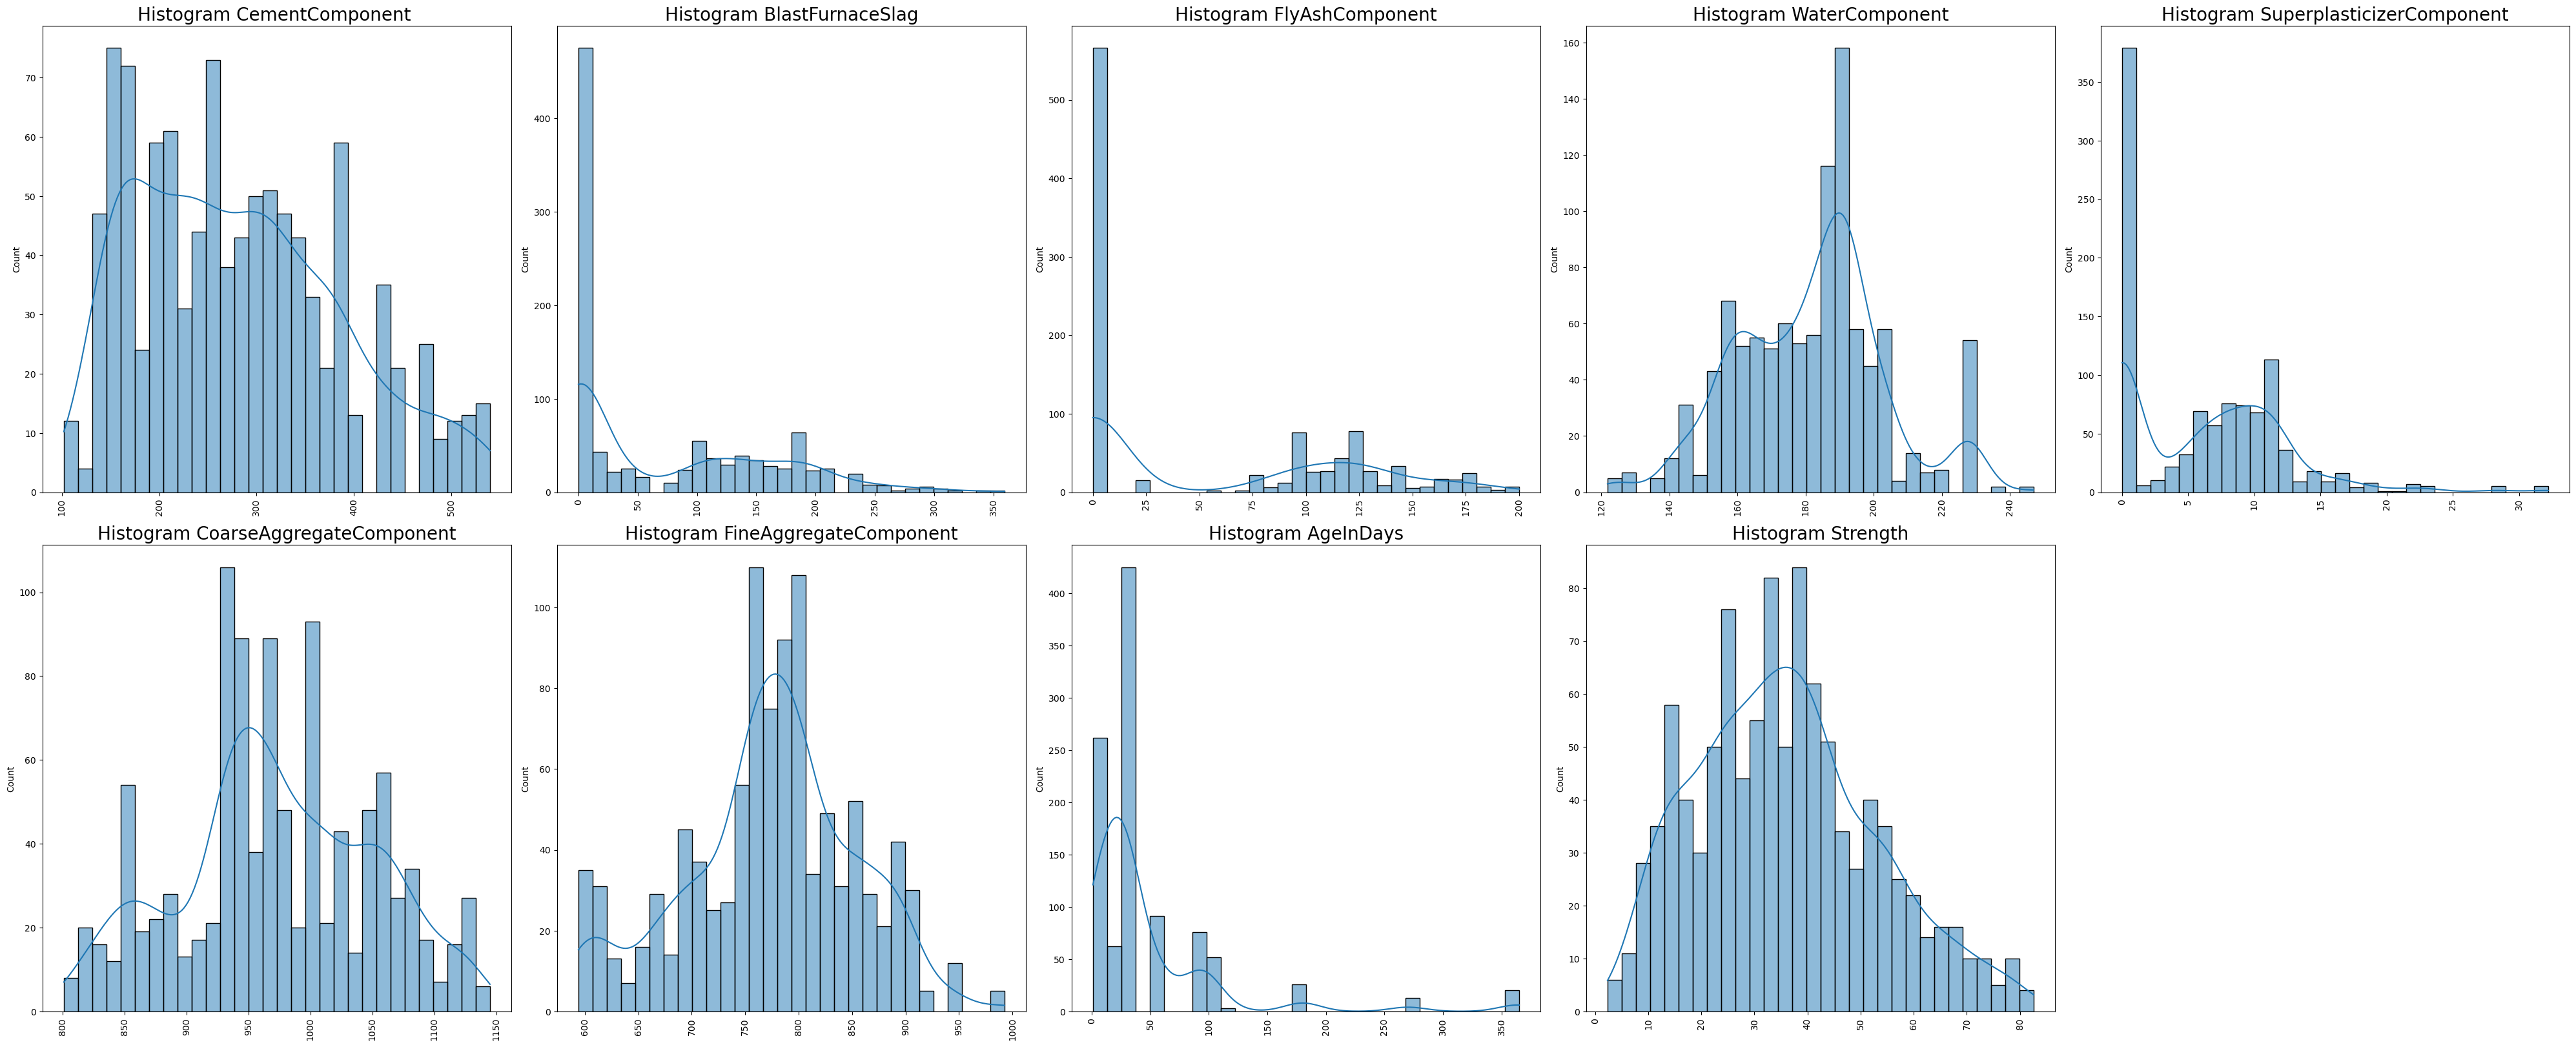

In [3]:
def plot_histograms(df):
    plt.figure(figsize=(40, 40)) 
    for i, feature in enumerate(df.columns, 1):
        plt.subplot(5, 5, i)  
        sns.histplot(df[feature], bins=30, kde=True)  
        plt.title(f'Histogram {feature}', fontsize=20)
        plt.xticks(rotation=90, fontsize=10)  
        plt.xlabel('')  
    plt.tight_layout()
    plt.show()

# Call the function to plot histograms for the 'autos' DataFrame
plot_histograms(df)

# Step 4, 5. EDA

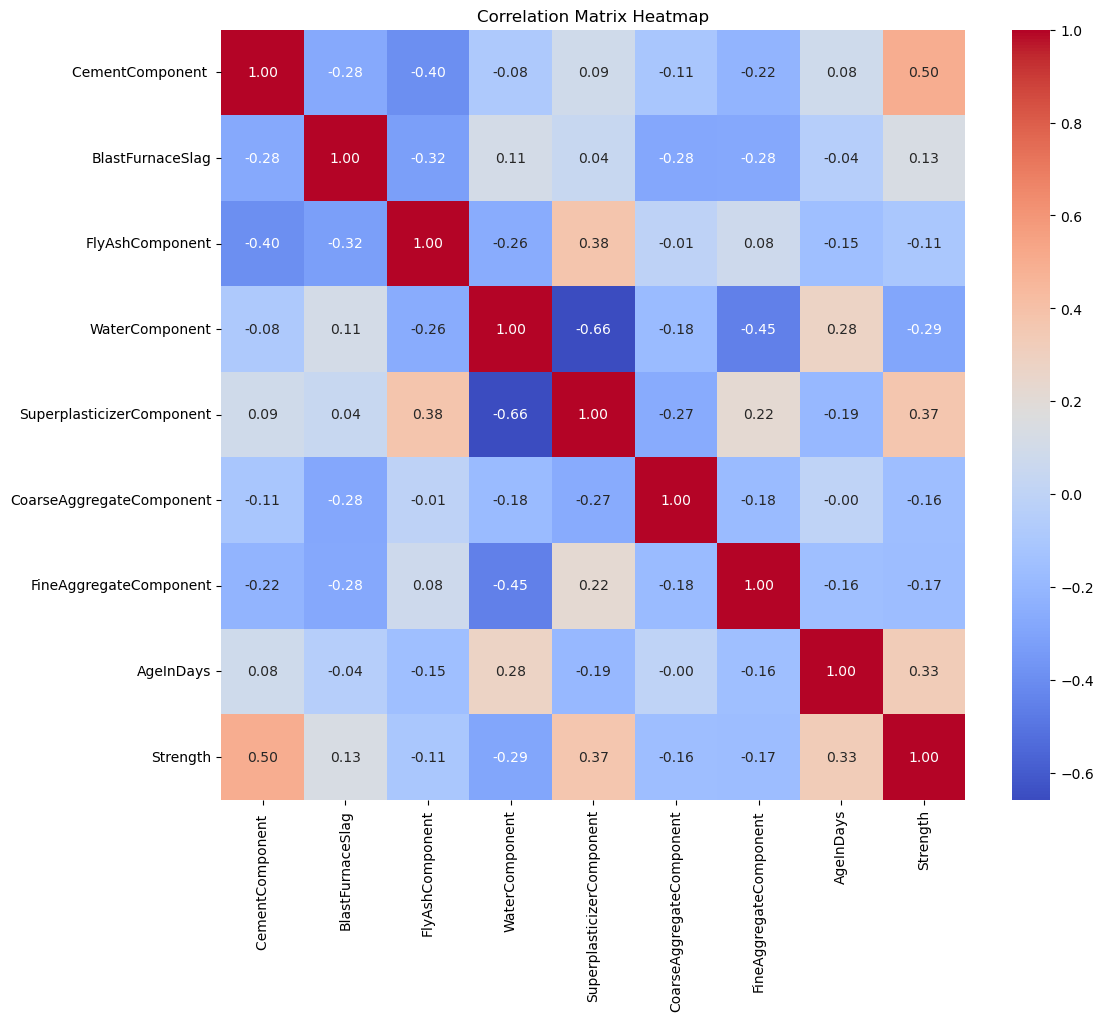

In [4]:
# Check the correlation
corr_matrix = df.corr()

# Plotting the heatmap
plt.figure(figsize=(12, 10))  # Размер графика
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', cbar=True)
plt.title('Correlation Matrix Heatmap')
plt.show()

# Deleting a Highly Correlated Feature
df = df.drop(columns=['SuperplasticizerComponent'])

In [5]:
# # Decision 1: Binary Encoding for 2 featues based on their distribution
for col in ['BlastFurnaceSlag', 'FlyAshComponent']:
    df[col] = (df[col] > 0).astype(int)

# Decision 2: KBins for the rest of the features based on their distribution
kbins = KBinsDiscretizer(n_bins=7, encode='ordinal', strategy='uniform')
df['CementComponent '] = kbins.fit_transform(df[['CementComponent ']]) 

kbins = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform')
df['CoarseAggregateComponent'] = kbins.fit_transform(df[['CoarseAggregateComponent']]) 
df['FineAggregateComponent'] = kbins.fit_transform(df[['FineAggregateComponent']])
df['WaterComponent'] = kbins.fit_transform(df[['WaterComponent']])

# Decision 3: Experimented with creating a new feature, but it worsened performance.
# df['Components'] = df[FEATURES].gt(0).sum(axis=1)
# df.info()

# Step 6. Splitting the Data

In [6]:
# Data Splitting

TARGET = 'Strength'
FEATURES = [col for col in df.columns if col != TARGET]

y = df[TARGET]
y.info()

X = df.drop(TARGET, axis=1)
X.info()

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42  
)

<class 'pandas.core.series.Series'>
RangeIndex: 1030 entries, 0 to 1029
Series name: Strength
Non-Null Count  Dtype  
--------------  -----  
1030 non-null   float64
dtypes: float64(1)
memory usage: 8.2 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   CementComponent           1030 non-null   float64
 1   BlastFurnaceSlag          1030 non-null   int64  
 2   FlyAshComponent           1030 non-null   int64  
 3   WaterComponent            1030 non-null   float64
 4   CoarseAggregateComponent  1030 non-null   float64
 5   FineAggregateComponent    1030 non-null   float64
 6   AgeInDays                 1030 non-null   int64  
dtypes: float64(4), int64(3)
memory usage: 56.5 KB


# Step 7. Data Imputation

In [7]:
imputer = SimpleImputer().set_output(transform='pandas')

X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

# Step 8. Data Encoding

In [8]:
enc_auto = TargetEncoder(random_state=42).set_output(transform='pandas')

X_train = enc_auto.fit_transform(X_train, y_train)
X_test = enc_auto.transform(X_test)

# Step 9. Creating a Dataset for PyTorch: Converting to Tensors

In [9]:
class PyTorchDataset(Dataset):
    def __init__(self, X, y, scale=True):        
        self.X = X.values # from Pandas DataFrame to NumPy array
        self.y = y.values # from Pandas DataFrame to NumPy array
        
        if scale:
            sc = StandardScaler()
            self.X = sc.fit_transform(self.X)

    def __len__(self):
        #return size of a dataset
        return len(self.y)

    def __getitem__(self, idx):
        #supports indexing using dataset[i] to get the i-th row in a dataset
        
        X = torch.tensor(self.X[idx], dtype=torch.float32)
        y = torch.tensor(self.y[idx], dtype=torch.float32)        
        
        return X, y

# Step 10. Creating train and test datasets

In [10]:
train_dataset = PyTorchDataset(X_train, y_train)
test_dataset = PyTorchDataset(X_test, y_test)

# Step 11. Loading Batches of Data

In [11]:
train_dataloader = DataLoader(train_dataset,
                              batch_size=200,
                              num_workers=0
                             )

test_dataloader = DataLoader(test_dataset,
                              batch_size=200,
                              num_workers=0
                             )

# Test the DataLoader
for batch in train_dataloader:
    print(batch)
    break

[tensor([[-1.4595,  0.9306, -1.3448,  ..., -0.3889,  0.1042,  0.0242],
        [ 1.6520,  0.8821, -0.7492,  ...,  2.3861, -0.0687,  0.1398],
        [-0.1912, -0.9311, -0.7535,  ..., -0.3248, -0.1035, -1.5325],
        ...,
        [ 2.0631,  1.1821,  1.3500,  ...,  2.4653, -0.3414,  3.0944],
        [ 1.8509,  0.6293,  0.3119,  ...,  0.2247,  2.1090,  0.0506],
        [-0.1912,  0.8753,  0.8937,  ..., -0.3248, -0.0704,  0.1342]]), tensor([27.6800, 62.0500, 23.8000, 33.4000,  7.4000, 27.7700, 18.2900, 48.5900,
        39.7000,  4.5700, 13.2900, 36.9700, 22.5300, 71.3000, 25.6100, 76.2400,
        62.9400, 17.5400, 41.0500, 21.8600, 47.1300, 16.5000, 22.7200, 29.7200,
        19.9300,  9.6200, 39.0500, 42.1300, 39.3200, 34.4900, 28.1000, 38.6000,
        53.7700,  7.3200, 32.8200, 43.3800, 55.1600, 35.2300, 66.7000, 30.8800,
        76.8000, 17.9600, 55.0600, 64.3000, 33.8000, 45.9400, 37.2600, 24.8500,
        40.1500, 13.5400, 32.8800, 17.5700, 21.5400, 17.8400, 23.4000, 55.5500,
    

# Step 12. Model Class Implementation

In [12]:
class LinearModel(torch.nn.Module):
    def __init__(self, in_dim, out_dim=1):
        super().__init__()
        self.layer1 = nn.Linear(in_dim, 256)
        self.dropout1 = nn.Dropout(p=0.5)
        self.act1 = nn.ReLU()
        
        self.layer2 = nn.Linear(256, 128)
        self.act2 = nn.ReLU()
        
        self.layer3 = nn.Linear(128, 64)
        self.act3 = nn.ReLU()
        
        self.layer4 = nn.Linear(64, out_dim)
    
    def forward(self, x):
        x = self.act1(self.layer1(x))
        x = self.act2(self.layer2(x))
        x = self.act3(self.layer3(x))
        x = self.layer4(x)  
        return x
    

# Step 13. Model Initialization and Optimization

In [13]:
# %%
# Initialize the model
model = LinearModel(in_dim=X_train.shape[1], out_dim=1)
  
# Define the loss function 
criterion = nn.MSELoss()

# Experimenting with Different Optimizers
# optimizer = torch.optim.Adam(model.parameters(), lr=0.000085, weight_decay=1e-4)
# optimizer = torch.optim.SGD(model.parameters(), lr=0.000085, momentum=0.3)
# optimizer = torch.optim.RMSprop(model.parameters(), lr=0.000085, alpha=0.99)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.000085, weight_decay=1e-4)


train_mses = []
train_maes = []
train_r2s = []

test_mses = []
test_maes = []
test_r2s = []

# Step 14. Model Training and Prediction

In [14]:
num_epochs = 2000

for epoch in range(num_epochs):
    
    # Train step
    
    model.train()
    
    y_pred_train = []
    
    for data in train_dataloader:
        # Get and prepare inputs
        inputs, targets = data
        inputs, targets = inputs.float(), targets.float()
        targets = targets.reshape((targets.shape[0], 1))
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        y_pred_train.extend(outputs.cpu().detach().numpy())
    
    # Calculate metrics for training set
    train_mses.append(mean_squared_error(y_train, y_pred_train))
    train_maes.append(mean_absolute_error(y_train, y_pred_train))
    train_r2s.append(r2_score(y_train, y_pred_train))
    
    # Eval step
    
    model.eval()
    
    y_pred_test = []
    
    with torch.no_grad():
        
        for data in test_dataloader:
            # Get and prepare inputs
            inputs, targets = data
            inputs, targets = inputs.float(), targets.float()
            targets = targets.reshape((targets.shape[0], 1))
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            # No backward pass
            
            y_pred_test.extend(outputs.cpu().detach().numpy())
        
    # Calculate metrics for test set
    test_mses.append(mean_squared_error(y_test, y_pred_test))
    test_maes.append(mean_absolute_error(y_test, y_pred_test))
    test_r2s.append(r2_score(y_test, y_pred_test))
    
    
   # Print metrics every 10 epochs
    if (epoch + 1) % 100 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}]:")
        print(f"  Train - MSE: {train_mses[-1]:.4f}, MAE: {train_maes[-1]:.4f}, R²: {train_r2s[-1]:.4f}")
        print(f"  Test  - MSE: {test_mses[-1]:.4f}, MAE: {test_maes[-1]:.4f}, R²: {test_r2s[-1]:.4f}")


Epoch [100/2000]:
  Train - MSE: 162.2560, MAE: 10.0271, R²: 0.4288
  Test  - MSE: 126.5264, MAE: 9.0336, R²: 0.5090
Epoch [200/2000]:
  Train - MSE: 118.2185, MAE: 8.3312, R²: 0.5839
  Test  - MSE: 84.4901, MAE: 7.0942, R²: 0.6721
Epoch [300/2000]:
  Train - MSE: 94.6907, MAE: 7.4760, R²: 0.6667
  Test  - MSE: 67.3885, MAE: 6.4333, R²: 0.7385
Epoch [400/2000]:
  Train - MSE: 77.3298, MAE: 6.7411, R²: 0.7278
  Test  - MSE: 57.5429, MAE: 6.1533, R²: 0.7767
Epoch [500/2000]:
  Train - MSE: 65.3105, MAE: 6.1561, R²: 0.7701
  Test  - MSE: 52.0264, MAE: 5.8886, R²: 0.7981
Epoch [600/2000]:
  Train - MSE: 57.3239, MAE: 5.7124, R²: 0.7982
  Test  - MSE: 49.1646, MAE: 5.6642, R²: 0.8092
Epoch [700/2000]:
  Train - MSE: 51.8622, MAE: 5.4013, R²: 0.8174
  Test  - MSE: 47.5238, MAE: 5.5732, R²: 0.8156
Epoch [800/2000]:
  Train - MSE: 47.9766, MAE: 5.1734, R²: 0.8311
  Test  - MSE: 46.6422, MAE: 5.5254, R²: 0.8190
Epoch [900/2000]:
  Train - MSE: 44.9024, MAE: 4.9849, R²: 0.8419
  Test  - MSE: 46.

# Step 15. Plot MSE

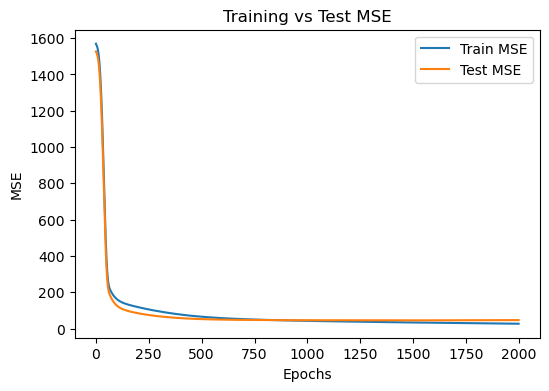

In [15]:
plt.figure(figsize=(6, 4))
plt.plot(train_mses, label='Train MSE')
plt.plot(test_mses, label='Test MSE')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.title('Training vs Test MSE')
plt.show()

# Step 16. Plot MAE

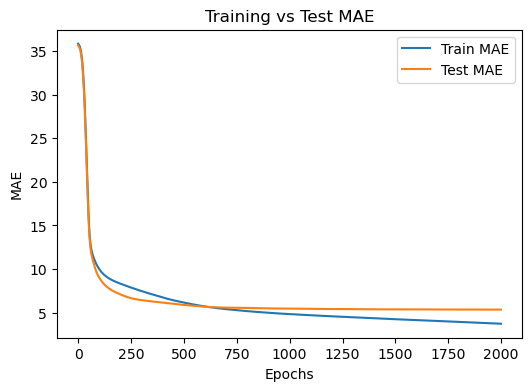

In [16]:
plt.figure(figsize=(6, 4))
plt.plot(train_maes, label='Train MAE')
plt.plot(test_maes, label='Test MAE')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.title('Training vs Test MAE')
plt.show()

# Step 17. Plot R²

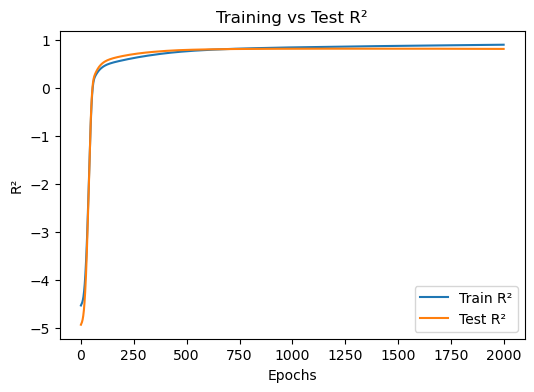

In [17]:
plt.figure(figsize=(6, 4))
plt.plot(train_r2s, label='Train R²')
plt.plot(test_r2s, label='Test R²')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('R²')
plt.title('Training vs Test R²')
plt.show()


# Step 18. Conclusion

## Summary of My Work
During the preparation of the data for building my deep learning model, I completed the following steps:

### Feature Removal:
I removed the SuperplasticizerComponent feature because it had a high correlation with other features. This decision helped me avoid multicollinearity and improve the model's stability.

### Binary Transformation of Features:
For the features BlastFurnaceSlag and FlyAshComponent, I applied binary encoding: values > 0 were converted to 1, and the rest to 0. This decision was based on analyzing their distributions, where most values were 0, and the remaining values were unevenly distributed. This transformation simplified the data and made it easier to interpret in the context of the prediction task.

### Discretization of Continuous Features:
For features like CementComponent, CoarseAggregateComponent, FineAggregateComponent, and WaterComponent, I used the KBinsDiscretizer method. The number of bins was chosen based on a visual assessment of their distributions, ensuring meaningful segmentation of the data.

### Handling Missing Values:
Even though my dataset did not contain missing values, I used SimpleImputer to prevent potential errors when experimenting with different optimizers.

### Encoding Categorical Data:
I applied TargetEncoder to encode categorical data while retaining information about the target variable.

### Data Scaling:
I scaled the data using StandardScaler within a custom PyTorchDataset class. After scaling, I converted the data into tensors for training my model.

### Model Development and Training:
I built a neural network with four fully connected layers using ReLU activation and Dropout regularization. I set the loss function to MSELoss.
For training, I used the AdamW optimizer with lr=0.000085 and weight_decay=1e-4. These parameters were selected after running several experiments with different optimizers and learning rates. I added weight_decay in the optimizer and applied Dropout on the first layer to prevent overfitting. The batch size was set to 200 rows to ensure stable gradient updates during training.

### Model Results
 - Mean Squared Error (MSE): ~45 (good result)
 - Mean Absolute Error (MAE): ~5.4 (good result)
 - R² (Coefficient of Determination): ~0.82 (excellent result)

## Possible Improvement

### Hyperparameter Optimization: 
I could use GridSearch or Bayesian optimization to fine-tune parameters like lr, weight_decay, and the architecture of my neural network (e.g., layer sizes and the number of neurons).

### Data Augmentation: 
I plan to explore the possibility of creating new features based on domain knowledge. For instance, I could consider interactions between components or the proportion of one component relative to the total.

### Improving Input Data: 
Applying non-linear transformations, like logarithmic transformations, to continuous features might help smooth outliers and reduce data variance.

### Early Stopping: 
Adding early stopping criteria could prevent unnecessary epochs and help avoid potential overfitting.
